In [0]:
# Import the libraries
import numpy as np
import gym
import sys
import matplotlib.pyplot as plt
from collections import defaultdict, deque
from plot_utils import plot_values
import check_test

%matplotlib inline



# 1. Explore CliffWalking Environment



In [0]:
# Making an instance of environment
env = gym.make('CliffWalking-v0')

In [0]:
# Print the state space
print("State Space: \n", env.observation_space)

State Space: 
 Discrete(48)


The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

In [0]:
# Print the action space and state space
print("Action Space: \n", env.action_space, "\n")

Action Space: 
 Discrete(4) 



The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.

In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

In [0]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


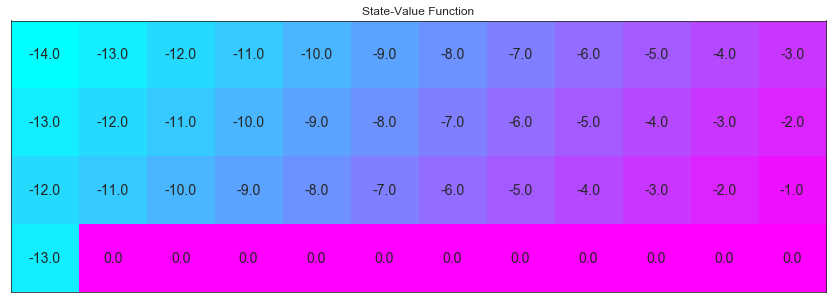

In [0]:
# Visualize the optimal state-value function
plot_values(V_opt)

<br>

# 2. TEMPORAL DIFFERENCE

<hr>

In this section, you will write your own implementation of TD prediction (for estimating the state-value function).

We will begin by investigating a policy where the agent moves:
- `RIGHT` in states `0` through `10`, inclusive,  
- `DOWN` in states `11`, `23`, and `35`, and
- `UP` in states `12` through `22`, inclusive, states `24` through `34`, inclusive, and state `36`.

The policy is specified and printed below.  Note that states where the agent does not choose an action have been marked with `-1`.

In [0]:
# Define a policy
policy = np.hstack([1*np.ones(11), 2, 0, np.zeros(10), 2, 0, np.zeros(10), 2, 0, -1*np.ones(11)])

In [0]:
# Print the policy
print("\nPolicy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1): \n")
print(policy.reshape(4,12))


Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1): 

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]


Run the next cell to visualize the state-value function that corresponds to this policy.  Make sure that you take the time to understand why this is the corresponding value function!

In [0]:
# Define the state-value function corresponding the defined policy
V_true = np.zeros((4,12))
for i in range(3):
    V_true[0:12][i] = -np.arange(3, 15)[::-1] - i
V_true[1][11] = -2
V_true[2][11] = -1
V_true[3][0] = -17

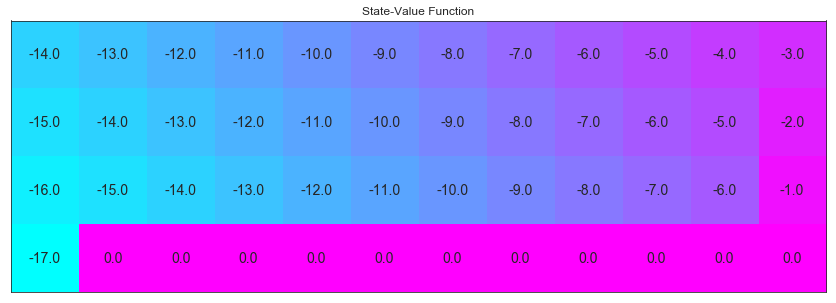

In [0]:
# Visualize the state-value function
plot_values(V_true)

The above figure is what you will try to approximate through the TD prediction algorithm.

Now we will write down our implementation of Temporal-Difference (TD) Prediction or TD(0). The pseudocode for TD(0) (or one-step TD) can be found below.

<img width="500px" src="assets/one-step-TD.png">

Please complete the function in the code cell below.

In [0]:
# Temporal-Difference (TD) Prediction or TD(0)
def td_prediction(env, num_episodes, policy, alpha, gamma=1.0):
    """
    Implementation for Temporal-Difference (TD) Prediction or TD(0).
    
    ARGUMENTS
    ---------------------------
        - env: This is an instance of an OpenAI Gym environment.
        - num_episodes: This is the number of episodes that are generated through agent-environment interaction.
        - policy: This is a 1D numpy array with policy.shape equal to the number of states (env.nS). policy[s] 
                  returns the action that the agent chooses when in state s.
        - alpha: This is the step-size parameter for the update step.
        - gamma: This is the discount rate. It must be a value between 0 and 1, inclusive (default value: 1).
    
    RETURNS
    ---------------------------
        - V: This is a dictionary where V[s] is the estimated value of state s.
        
    """
    
    # Initialize empty dictionaries of floats
    V = defaultdict(float)
    
    # Iterate through episodes
    for i_episode in range(1, num_episodes + 1):
        
        # Print episodes
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # Resets the state of the environment and returns an initial observation.
        state = env.reset()
        
        # Infinite loop
        while True:
            
            # Choose action A
            action = policy[state]
            
            # Run one timestep of the environment's dynamics (take action A, observe R, S')
            next_state, reward, done, info = env.step(action)
            
            # Perform updates
            V[state] = V[state] + (alpha * (reward + (gamma * V[next_state]) - V[state]))            
            
            # Update the current state to next state
            state = next_state
            
            # If terminal state then break the look
            if done:
                break   
                
    return V

Run the code cell below to test your implementation and visualize the estimated state-value function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [0]:
# Evaluate the policy & reshape the state-value function
V_pred = td_prediction(env, 5000, policy, .01)

Episode 5000/5000

**<span style="color: green;">PASSED</span>**

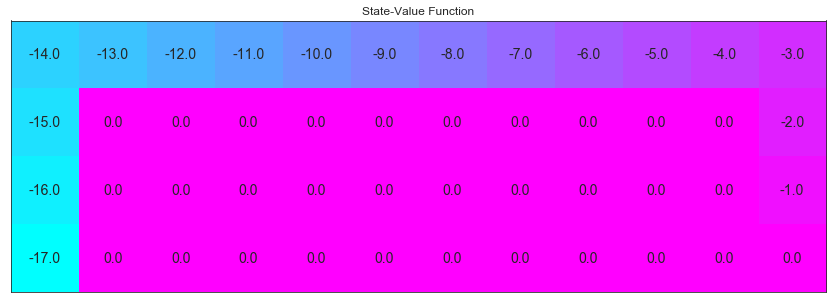

In [0]:
# Visualize
V_pred_plot = np.reshape([V_pred[key] if key in V_pred else 0 for key in np.arange(48)], (4,12)) 
check_test.run_check('td_prediction_check', V_pred_plot)
plot_values(V_pred_plot)

How close is your estimated state-value function to the true state-value function corresponding to the policy?  

You might notice that some of the state values are not estimated by the agent.  This is because under this policy, the agent will not visit all of the states.  In the TD prediction algorithm, the agent can only estimate the values corresponding to states that are visited.

<br>

# 4. Q-learning



In this section, you will write your own implementation of the Q-learning control algorithm.

The pseudocode for Sarsamax (or Q-learning) can be found below.

<img width="700px" src="assets/sarsamax.png">

Please complete the function in the code cell below.

In [0]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    """
    Implementation of the Sarsamax (aka Q-learning) control algorithm.
    
    ARGUMENTS
    -------------------------
        - env: This is an instance of an OpenAI Gym environment.
        - num_episodes: This is the number of episodes that are generated through agent-environment interaction.
        - alpha: This is the step-size parameter for the update step.
        - gamma: This is the discount rate. It must be a value between 0 and 1, inclusive (default value: 1).
    
    RETURNS 
    -------------------------
        - Q: This is a dictionary (of one-dimensional arrays) where Q[s][a] is the estimated action value 
             corresponding to state s and action a.
    
    """
    # Initialize action-value function
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # Initialize performance monitor
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)
    scores = deque(maxlen=num_episodes)
                   
    # Iterate through episodes
    for i_episode in range(1, num_episodes+1):
                   
        # Print out the episodes
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
                   
        # Initialize score
        score = 0
                   
        # Resets the state of the environment and get an initial observation
        state = env.reset()
                   
        # Infinite loop
        while True:
                   
            # Get epsilon-greedy action probabilities
            policy_s = epsilon_greedy_probs(env, Q[state], i_episode)
                   
            # Pick next action A
            action = np.random.choice(np.arange(env.nA), p=policy_s)
                   
            # Take action A, observe R, S'
            next_state, reward, done, info = env.step(action)
                   
            # aAdd reward to score
            score += reward
                   
            # Update Q
            Q[state][action] = update_Q(Q[state][action], np.max(Q[next_state]), \
                                                  reward, alpha, gamma)        
            # Update current state to next state
            state = next_state
                   
            # If S is terminal then break the loop
            if done:
                   
                # Append score
                tmp_scores.append(score)
                   
                # Break
                break
                   
        # Get scores for plotting
        if (i_episode % plot_every == 0):
            scores.append(np.mean(tmp_scores))
                   
    # Visualize the performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
                   
    # Print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
                   
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

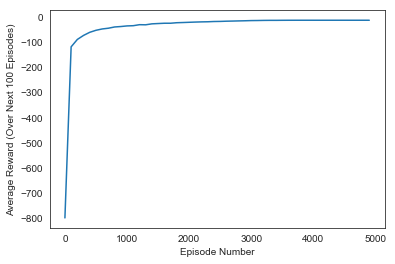

Best Average Reward over 100 Episodes:  -13.0


In [0]:
# Get the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

In [0]:
# Get the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  1  0  1  0  3  1  1  1  3  1  2]
 [ 0  2  0  1  3  1  1  1  1  2  3  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


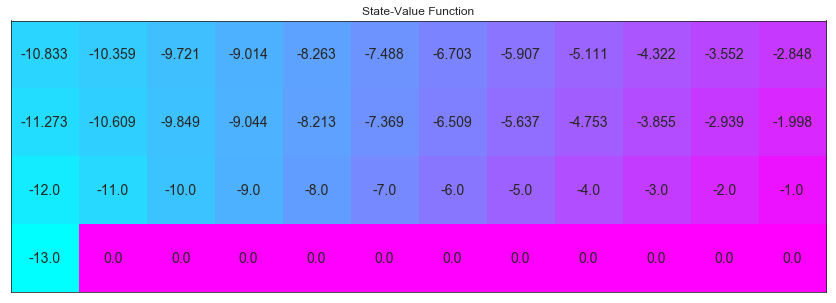

In [0]:
# Visualize the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])